In [1]:
from micromind import MicroMind, Metric
from micromind.networks import PhiNet
from micromind.utils.parse import parse_arguments

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from matplotlib import pyplot as plt

In [2]:
batch_size = 128

transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
            
trainset = torchvision.datasets.CIFAR100(
    root="data/cifar-100", train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR100(
    root="data/cifar-100", train=False, download=True, transform=transform
)

print(len(trainset))
val_size = 5000
train_size = len(trainset) - val_size
train, val = torch.utils.data.random_split(trainset, [train_size, val_size])

print(len(train), len(val))

trainloader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=1
)

valloader = torch.utils.data.DataLoader(
    val, batch_size=batch_size, shuffle=False, num_workers=1
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified
50000
45000 5000


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
elif torch.backends.mps.is_available: 
    device = torch.device("mps")
    print("Running on the MPS")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [16]:
class ImageClassification(MicroMind):

    # test 1 with n as input vector size and m classes custom d
    # n has to be calculated from the output of the neural network of the feature extractor

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.modules["feature_extractor"] = PhiNet(
            (3, 32, 32), include_top=True, num_classes=100, alpha=3
        )        
                
        self.modules["feature_extractor"].load_state_dict(torch.load("./pretrained/a3/exp/save/epoch_4_val_loss_2.3051.ckpt", map_location=device)["feature_extractor"])

    def forward(self, batch):
        return self.modules["feature_extractor"](batch[0])

    def compute_loss(self, pred, batch):
        return nn.CrossEntropyLoss()(pred, batch[1])


In [14]:
import argparse

def parse_test():
    parser = argparse.ArgumentParser(description="General configuration for micromind.")

    parser.add_argument("--lr", type=float, default=0.001, help="Learning rate.")
    parser.add_argument(
        "--optimizer",
        dest="opt",
        default="adam",
        choices=["adam", "sgd"],
        help="Optimizer name.",
    )
    parser.add_argument(
        "--experiment_name", default="exp", help="Name of the experiment."
    )
    parser.add_argument(
        "--output_folder", default="results", help="Output folder path."
    )
    parser.add_argument(
        "--debug",
        action="store_true",
        help="Run in debug mode to check train and validation steps.",
    )
    parser.add_argument(
        '--d', 
        type=int
    )

    args = parser.parse_args("")
    return args

In [17]:
# This is used ONLY if you are not using argparse to get the hparams
hparams = parse_test()

m = ImageClassification(hparams)


In [ ]:
def compute_accuracy(pred, batch):        
        tmp = (pred.argmax(1) == batch[1]).float()
        return tmp


acc = Metric(name="accuracy", fn=compute_accuracy)

m.train(
    epochs=2,
    datasets={"train": valloader, "val": trainloader},
    metrics=[acc],
    debug=hparams.debug,
)

m.test(
    datasets={"test": testloader},
)

2023-10-29 14:26:20.132 | INFO     | micromind.core:train:407 - Starting from epoch 0. Training is scheduled for 2 epochs.


Set device to  cuda


Validation...: 100%|##########| 40/40 [00:03<00:00, 12.94batches/s, loss=1.05] 
2023-10-29 14:26:51.139 | INFO     | micromind.utils.checkpointer:__call__:51 - Epoch 0: train_accuracy: 0.70 - train_loss: 1.00; val_accuracy: 0.6889 - val_loss: 1.0542.

Validation...: 100%|##########| 40/40 [00:02<00:00, 13.54batches/s, loss=1.28]
2023-10-29 14:27:22.057 | INFO     | micromind.utils.checkpointer:__call__:51 - Epoch 1: train_accuracy: 0.79 - train_loss: 0.70; val_accuracy: 0.6398 - val_loss: 1.2799.

2023-10-29 14:27:22.326 | INFO     | micromind.utils.checkpointer:__call__:90 - Generated better checkpoint. Deleting results/exp/save/epoch_0_val_loss_1.0542.ckpt.
Testing...: 100%|##########| 79/79 [00:05<00:00, 14.35batches/s, loss=2.48]
2023-10-29 14:27:27.848 | INFO     | micromind.core:test:559 - Testing test_accuracy: 0.48 - test_loss: 2.48; 


'Testing test_accuracy: 0.48 - test_loss: 2.48; '

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

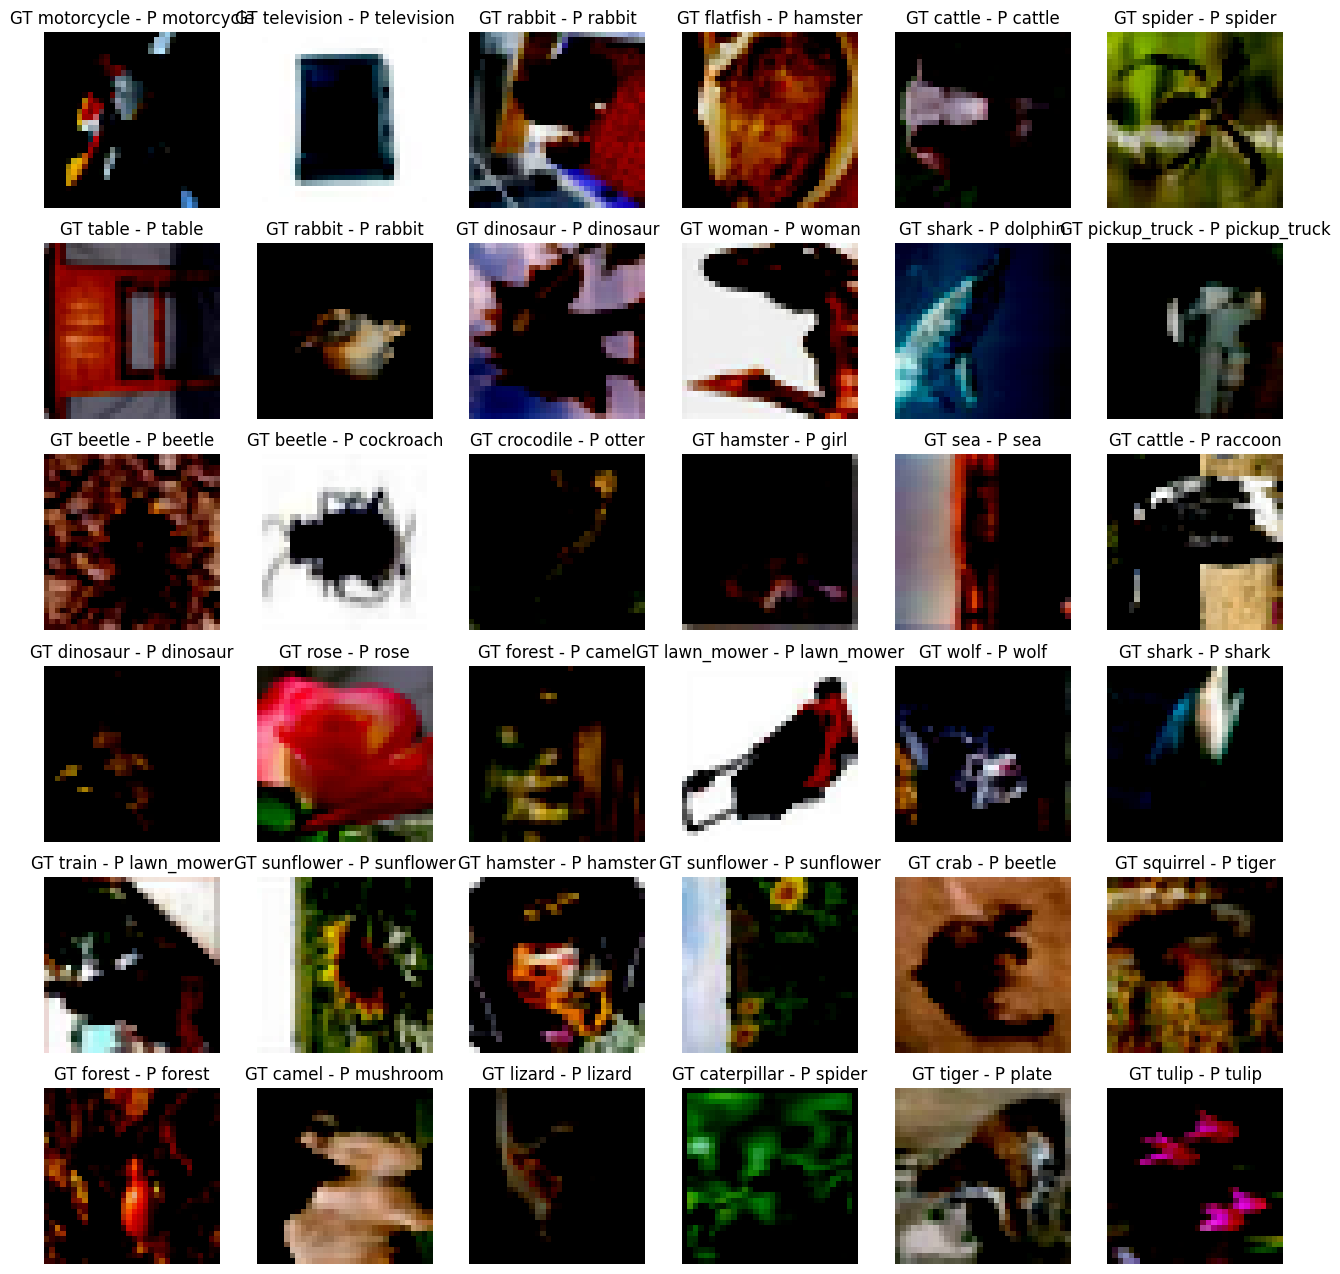

tensor(0.6562)
true tensor(84) tot 128


In [18]:
train_features, train_labels = next(iter(trainloader))

classes = train.dataset.classes

m.modules["feature_extractor"].eval()
res = m.modules["feature_extractor"](train_features)

pred = torch.argmax(res, dim=1)

equal = pred.to('cpu') == train_labels

# print(pred)
# print(train_labels)
# print(equal)

accuracy = sum(equal)/len(equal)

figure = plt.figure(figsize=(16, 16))
cols, rows = 6, 6
for i in range(1, cols * rows + 1):   
    figure.add_subplot(rows, cols, i)    
    plt.title("GT " + classes[train_labels[i]] + " - P " + classes[pred[i]] )
    plt.axis("off")
    plt.imshow(train_features[i].T)
plt.show()

print(accuracy)
print("true", sum(equal), "tot", len(equal))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

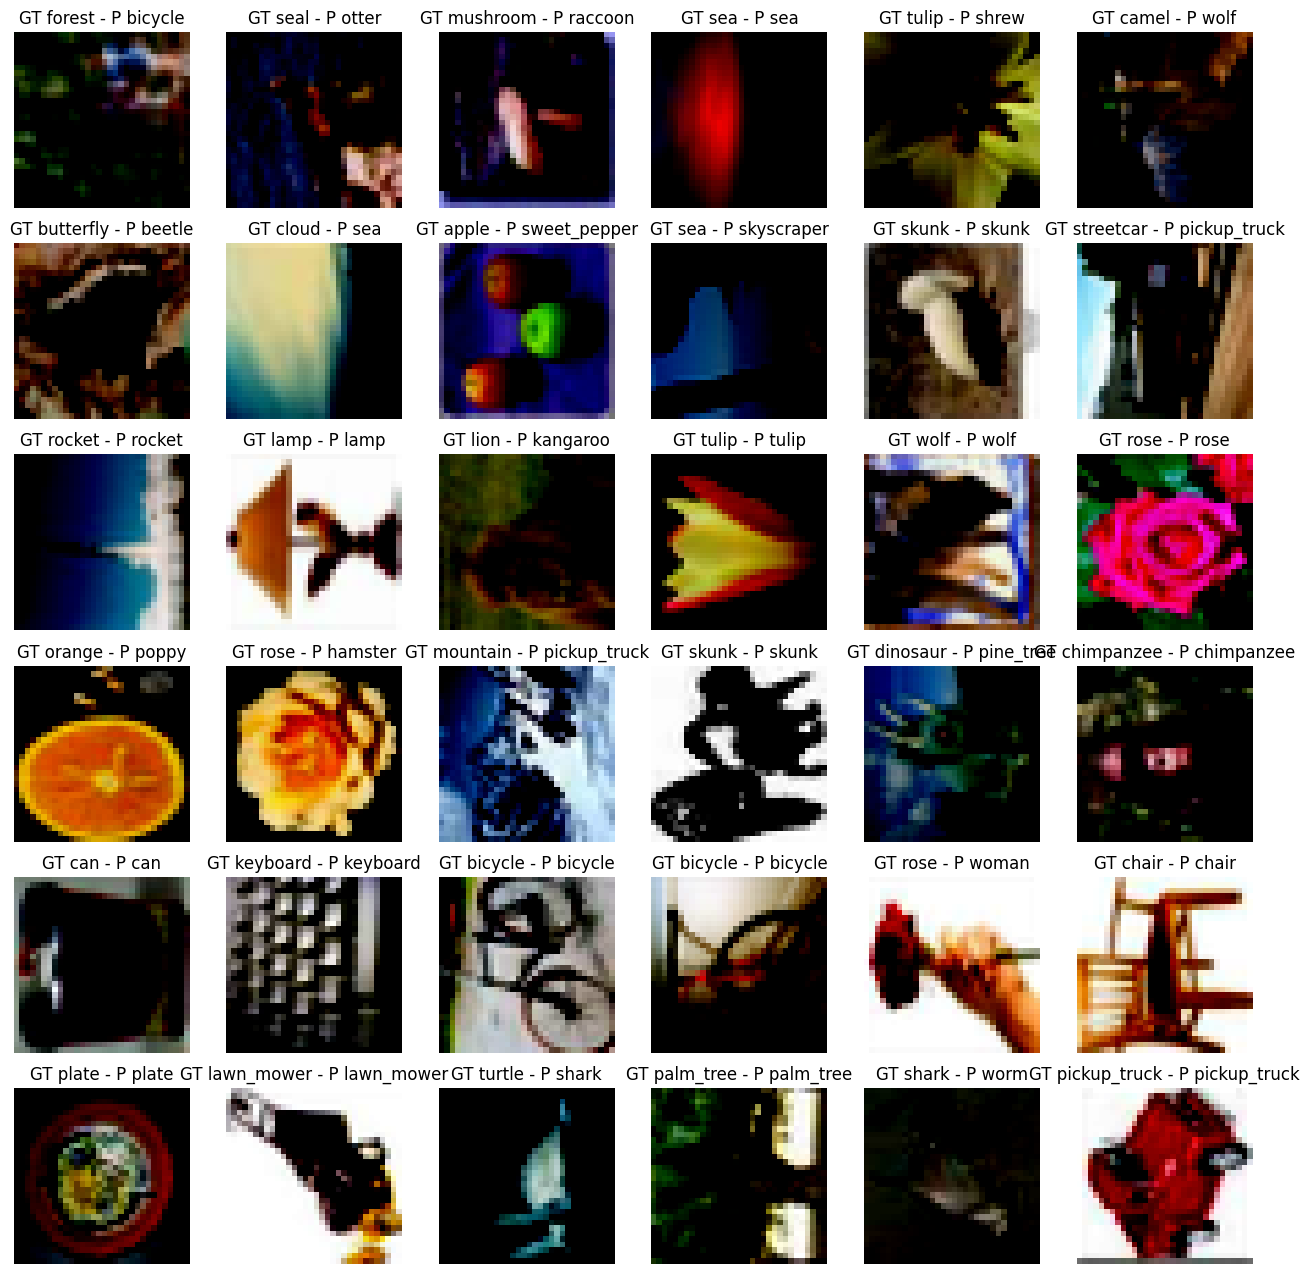

tensor(0.4766)
true tensor(61) tot 128


In [20]:
test_features, test_labels = next(iter(testloader))

res_t = m.modules["feature_extractor"](test_features)

classes = testloader.dataset.classes

pred_t = torch.argmax(res_t, dim=1)

equal_t = pred_t.to('cpu') == test_labels

# print(pred_t)
# print(test_labels)
# print(equal_t)

accuracy = sum(equal_t)/len(equal_t)

figure = plt.figure(figsize=(16, 16))
cols, rows = 6, 6
for i in range(1, cols * rows + 1):   
    figure.add_subplot(rows, cols, i)    
    plt.title("GT " + classes[test_labels[i]] + " - P " + classes[pred_t[i]] )
    plt.axis("off")
    plt.imshow(test_features[i].T)
plt.show()

print(accuracy)
print("true", sum(equal_t), "tot", len(equal_t))
